<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [0]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('gdrive/My Drive/storage_sample_stage5.h5', 'train_df',mode='r')
df_final_test = read_hdf('gdrive/My Drive/storage_sample_stage5.h5', 'test_df',mode='r')

In [16]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d'],
      dtype='object')

## Adding another feature PREFERENTIAL ATTACHMENT

**Preferential Attachment**: One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity.

In [17]:
# FOR FOLLOWERS
# FOR TRAIN DATA

source_followers=np.array(df_final_train['num_followers_s'])
dest_followers=np.array(df_final_train['num_followers_d'])
preferential_followers=[]
for i in range(len(source_followers)):
    preferential_followers.append(source_followers[i]*dest_followers[i])
df_final_train['PRE_ATTACH_FOLLOWERS']= preferential_followers
df_final_train.head(5)


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,num_followers_d,PRE_ATTACH_FOLLOWERS
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,1.043044e-05,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,1.068946e-06,1.192357e-12,2.279485e-12,3.580837e-12,-7.216133e-13,3.925975e-13,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,6,36
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,0,1,2,0.102598,0.127000,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,7.051088e-13,-8.250564e-11,-1.717702e-10,3.705016e-02,1.032392e-11,7.207497e-10,1.644399e-12,-2.047752e-10,-3.943936e-10,8.617541e-02,2.399540e-11,1.738682e-09,2.685878e-13,-3.316849e-11,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,94,8836
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,0,1,2,0.185695,0.154303,0.339999,0.028653,0.525694,0.494302,6.211019e-07,5.179801e-07,0.000885,0.000855,7.730764e-114,4.067322e-114,2.681298e-113,2.199205e-113,-4.900734e-18,1.096831e-18,-6.816555e-19,-2.226453e-18,6.710556e-19,-8.161336e-19,-2.606312e-18,6.392474e-19,-4.245830e-19,-1.315747e-18,3.849627e-19,-1.131971e-18,-1.510265e-18,1.454979e-19,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,28,784
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,0,0,0.000000,0,1,6,0.288675,0.408248,0.696923,0.117851,0.985599,1.105172,2.998153e-07,1.704245e-06,0.000739,0.000773,5.443738e-17,4.139999e-16,2.413250e-14,6.688064e-15,-9.965436e-12,4.077137e-13,5.083778e-10,1.985267e-14,2.471968e-12,1.004354e-15,-2.629029e-13,1.428940e-11,9.146784e-11,8.590132e-12,2.406658e-10,7.638106e-15,-2.170899e-13,5.206150e-13,6.058498e-11,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,11,121
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,0,0,0.000000,0,0,-1,1.000000,0.301511,1.301511,0.301511,2.301511,1.603023,4.349180e-07,2.089590e-07,0.000751,0.000735,3.887821e-16,4.721269e-16,7.552255e-16,2.734009e-18,-3.408943e-13,1.125207e-13,3.190883e-07,8.550846e-14,1.405351e-13,7.172313e-15,-2.550169e-13,2.424636e-13,2.436301e-07,3.679960e-14,1.348520e-13,8.710393e-15,-4.795514e-13,1.521297e-13,1.197283e-07,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,1


In [18]:
# FOR FOLLOWERS
# FOR TEST DATA

source_followers=np.array(df_final_test['num_followers_s'])
dest_followers=np.array(df_final_test['num_followers_d'])
preferential_followers=[]
for i in range(len(source_followers)):
    preferential_followers.append(source_followers[i]*dest_followers[i])
df_final_test['PRE_ATTACH_FOLLOWERS']= preferential_followers
df_final_test.head(5)


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,num_followers_d,PRE_ATTACH_FOLLOWERS
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,0.000002,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,-9.987979e-12,2.283676e-13,1.439968e-10,6.136162e-13,4.188171e-13,5.983361e-15,-1.026186e-11,5.316372e-13,5.843225e-10,1.166047e-13,2.253356e-11,3.220367e-15,-2.148852e-13,1.883148e-13,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,14,196
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,0,0,0.000000,1,1,7,0.235702,0.707107,0.942809,0.166667,1.178511,1.649916,2.172064e-07,0.000001,0.000739,0.000801,1.702625e-19,2.706300e-15,2.522357e-16,5.277458e-15,-2.079151e-15,7.009864e-16,6.970710e-10,9.561769e-15,1.728794e-15,3.122935e-18,-1.960277e-11,2.861530e-11,1.939773e-08,1.907382e-12,3.797410e-11,4.992848e-14,-4.054309e-13,2.895682e-13,2.545382e-10,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,17,289
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,0,0,0.000000,0,1,5,0.301511,0.242536,0.544047,0.073127,0.845558,0.786583,1.853369e-06,0.000002,0.000789,0.000770,9.426796e-14,4.116616e-16,2.253244e-15,2.079387e-15,-1.782290e-11,2.389627e-11,1.443050e-06,2.358030e-12,2.689638e-12,1.739178e-12,-1.863934e-13,1.806783e-13,2.544597e-07,1.693295e-13,2.712748e-13,7.594641e-15,-4.148103e-13,4.618813e-12,1.122150e-05,1.778927e-12,2.740535e-13,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,10,100
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,0,0,0.000000,0,1,3,0.162221,0.301511,0.463733,0.048912,0.625954,0.765244,7.000791e-07,0.000002,0.000778,0.000884,9.876114e-14,1.039593e-13,1.511694e-14,3.478438e-14,-4.491246e-11,9.917404e-13,7.891250e-06,9.458624e-12,2.715848e-11,1.822074e-12,-1.070733e-10,2.888035e-12,2.070703e-05,7.229355e-12,3.563659e-11,1.917977e-12,-8.942488e-12,5.535630e-12,5.223676e-06,7.917166e-13,4.020707e-12,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,37,1369
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,4,7,6.136433,0,1,2,0.188982,0.250000,0.438982,0.047246,0.627964,0.688982,7.103008e-07,0.000001,0.000779,0.000840,1.557332e-15,1.096037e-14,5.180869e-15,1.296135e-14,-9.778448e-13,5.724610e-13,4.951883e-06,1.396834e-12,2.153249e-11,2.873183e-14,-2.275780e-11,1.007615e-12,2.517628e-06,1.394103e-10,2.961969e-11,2.022115e-13,-3.804979e-12,1.593011e-13,1.035016e-06,1.361574e-13,1.154623e-12,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,27,729


In [19]:
# FOR FOLLOWEES
# FOR TRAIN DATA

source_followees=np.array(df_final_train['num_followees_s'])
dest_followees=np.array(df_final_train['num_followees_d'])
preferential_followees=[]
for i in range(len(source_followees)):
    preferential_followees.append(source_followees[i]*dest_followees[i])
df_final_train['PRE_ATTACH_FOLLOWEES']= preferential_followees
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,num_followers_d,PRE_ATTACH_FOLLOWERS,PRE_ATTACH_FOLLOWEES
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,1.043044e-05,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,1.068946e-06,1.192357e-12,2.279485e-12,3.580837e-12,-7.216133e-13,3.925975e-13,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,6,36,120
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,0,1,2,0.102598,0.127,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,7.051088e-13,-8.250564e-11,-1.717702e-10,3.705016e-02,1.032392e-11,7.207497e-10,1.644399e-12,-2.047752e-10,-3.943936e-10,8.617541e-02,2.399540e-11,1.738682e-09,2.685878e-13,-3.316849e-11,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,94,8836,8662


In [20]:
# FOR FOLLOWEES
# FOR TEST DATA

source_followees=np.array(df_final_test['num_followees_s'])
dest_followees=np.array(df_final_test['num_followees_d'])
preferential_followees=[]
for i in range(len(source_followees)):
    preferential_followees.append(source_followees[i]*dest_followees[i])
df_final_test['PRE_ATTACH_FOLLOWEES']= preferential_followees
df_final_test.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,num_followers_d,PRE_ATTACH_FOLLOWERS,PRE_ATTACH_FOLLOWEES
0,848424,784690,1,0,0.0,0.029161,0.0,14,6,9,1,0,0.0,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,0.000002,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,-9.987979e-12,2.283676e-13,1.439968e-10,6.136162e-13,4.188171e-13,5.983361e-15,-1.026186e-11,5.316372e-13,5.843225e-10,1.166047e-13,2.253356e-11,3.220367e-15,-2.148852e-13,1.883148e-13,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,14,196,54
1,483294,1255532,1,0,0.0,0.000000,0.0,17,1,19,0,0,0.0,1,1,7,0.235702,0.707107,0.942809,0.166667,1.178511,1.649916,2.172064e-07,0.000001,0.000739,0.000801,1.702625e-19,2.706300e-15,2.522357e-16,5.277458e-15,-2.079151e-15,7.009864e-16,6.970710e-10,9.561769e-15,1.728794e-15,3.122935e-18,-1.960277e-11,2.861530e-11,1.939773e-08,1.907382e-12,3.797410e-11,4.992848e-14,-4.054309e-13,2.895682e-13,2.545382e-10,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,17,289,19


## Adding one more feature SVD-DOT

Previously we have calcuated the 6 dimensional svd features of nodes. Now we just take dot product of those 6 dimensional vectors to obtain SVD-DOT feature.

In [0]:
df_final_train['svd_dot_u'] = df_final_train['svd_u_s_1']*df_final_train['svd_u_d_1'] \
                              + df_final_train['svd_u_s_2']*df_final_train['svd_u_d_2'] \
                              + df_final_train['svd_u_s_3']*df_final_train['svd_u_d_3'] \
                              + df_final_train['svd_u_s_4']*df_final_train['svd_u_d_4'] \
                              + df_final_train['svd_u_s_5']*df_final_train['svd_u_d_5'] \
                              + df_final_train['svd_u_s_6']*df_final_train['svd_u_d_6'] 

In [0]:
df_final_train['svd_dot_v'] = df_final_train['svd_v_s_1']*df_final_train['svd_v_d_1'] \
                              + df_final_train['svd_v_s_2']*df_final_train['svd_v_d_2'] \
                              + df_final_train['svd_v_s_3']*df_final_train['svd_v_d_3'] \
                              + df_final_train['svd_v_s_4']*df_final_train['svd_v_d_4'] \
                              + df_final_train['svd_v_s_5']*df_final_train['svd_v_d_5'] \
                              + df_final_train['svd_v_s_6']*df_final_train['svd_v_d_6'] 

In [0]:
df_final_test['svd_dot_u'] = df_final_test['svd_u_s_1']*df_final_test['svd_u_d_1'] \
                              + df_final_test['svd_u_s_2']*df_final_test['svd_u_d_2'] \
                              + df_final_test['svd_u_s_3']*df_final_test['svd_u_d_3'] \
                              + df_final_test['svd_u_s_4']*df_final_test['svd_u_d_4'] \
                              + df_final_test['svd_u_s_5']*df_final_test['svd_u_d_5'] \
                              + df_final_test['svd_u_s_6']*df_final_test['svd_u_d_6'] 

In [0]:
df_final_test['svd_dot_v'] = df_final_test['svd_v_s_1']*df_final_test['svd_v_d_1'] \
                              + df_final_test['svd_v_s_2']*df_final_test['svd_v_d_2'] \
                              + df_final_test['svd_v_s_3']*df_final_test['svd_v_d_3'] \
                              + df_final_test['svd_v_s_4']*df_final_test['svd_v_d_4'] \
                              + df_final_test['svd_v_s_5']*df_final_test['svd_v_d_5'] \
                              + df_final_test['svd_v_s_6']*df_final_test['svd_v_d_6'] 

In [33]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,num_followers_d,PRE_ATTACH_FOLLOWERS,PRE_ATTACH_FOLLOWEES,svd_dot_u,svd_dot_v
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,1.043044e-05,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,1.068946e-06,1.192357e-12,2.279485e-12,3.580837e-12,-7.216133e-13,3.925975e-13,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,6,36,120,1.114958e-11,2.238775e-12
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,0,1,2,0.102598,0.127,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,7.051088e-13,-8.250564e-11,-1.717702e-10,3.705016e-02,1.032392e-11,7.207497e-10,1.644399e-12,-2.047752e-10,-3.943936e-10,8.617541e-02,2.399540e-11,1.738682e-09,2.685878e-13,-3.316849e-11,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,94,8836,8662,3.192812e-03,9.068719e-04


In [0]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [0]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

## XGBOOST CLASSIFICATION MODEL

#### HYPER PARAMETER TUNING

In [37]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
param_dist = {"eta" : [0.01 , 0.05 , 0.1] ,
              "max_depth" : [2,3,4],
              "n_estimators" : [40, 80, 150 , 400],
              "sample" : [0.7 , 0.8, 0.9] ,
              "min_child_weight" : [3,4,5,6],
              "gamma" : [0 , 0.1, 0.2],
              "colsample_bytree" : [0.7,0.8,0.9],
              "reg_lambda" : [200 ,300 ,400]}
n_iter = 20
xgb = XGBClassifier(objective='binary:logistic', nthreads=-1)
random_search_xgb = RandomizedSearchCV(xgb, param_distributions = param_dist,
                                       n_iter = n_iter , random_state = 42 )
random_search_xgb.fit(df_final_train,y_train)
estimators_xgb = random_search_xgb.best_params_
estimators_xgb

{'colsample_bytree': 0.7,
 'eta': 0.05,
 'gamma': 0,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 400,
 'reg_lambda': 200,
 'sample': 0.9}

#### Building model using best parameters

In [38]:
best_xgb = XGBClassifier(objective = 'binary:logistic',eval_metric = 'logloss' , eta = 0.05,max_depth = 4 ,colsample_bytree=0.7,
                        gamma = 0,min_child_weight = 5, n_estimators = 400 , reg_lambda = 200 , sample = 0.9)

best_xgb.fit(df_final_train,y_train)

y_train_pred = best_xgb.predict(df_final_train)
y_test_pred = best_xgb.predict(df_final_test)
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.978802401251072
Test f1 score 0.9282714740190879


In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


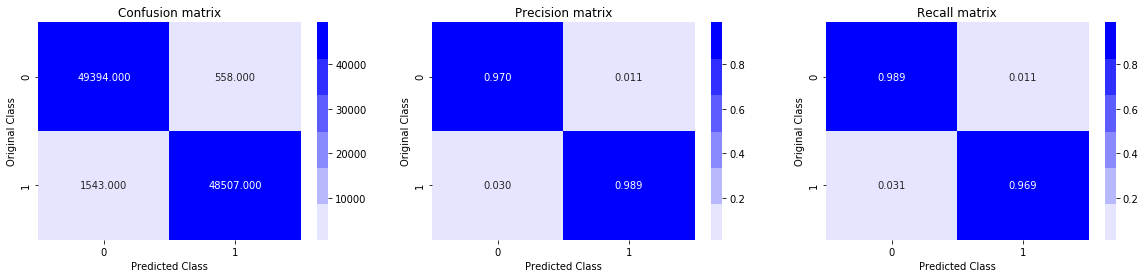

Test confusion_matrix


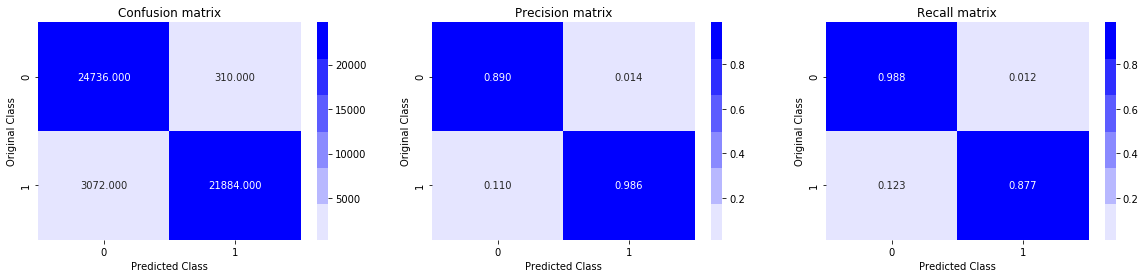

In [40]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

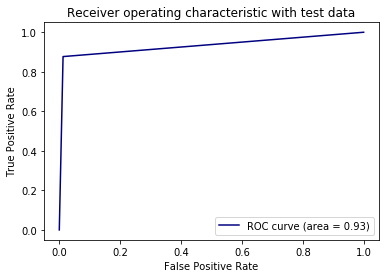

In [41]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

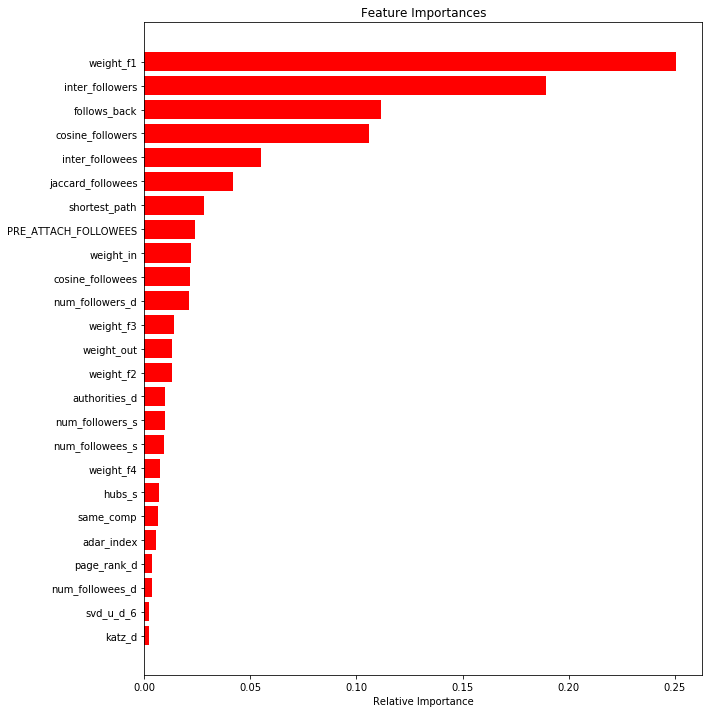

In [42]:
features = df_final_train.columns
importances = best_xgb.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**CONCLUSION:**

- The main challenge in this case study is to design the features which will be useful for prediction as there is no data except nodes.
- This main aim is to predict whether a link can be present between two nodes which can be helpful for friend recommendations in social network platforms.
- We can conclude that the graph is directed graph.
- Different techniques in graph theory and web pages are used like
- 1) follows back
- 2) shortest path
-3) Adar index
- 4) weakly connected graph
- 5) cosine and jaccard distances
- 6) katz centrality
- 7) page rank and HITS
- 8) SVD and SVD-DOT
- 9) Preferential attachment
- Basically different techniques are tried to see which works.Finally XGBOOST model is designed on top of these features with hyperparameter tuning.
- **Results: TRAIN F1-SCORE = 0.978 TEST F1-SCORE = 0.928**
- Features importances are also plotted where we can see which features worked for us. Finally we got a great F1-score above 91%.